In [1]:
!pip install seaborn


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame
from pyspark_dbscan.dbscan import process as process_dbscan
from scipy.spatial.distance import euclidean
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DoubleType
import os
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [3]:
# Have to use Java 8
os.environ['JAVA_HOME'] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_231.jdk/Contents/Home/"

In [4]:
spark = (
    SparkSession.builder.appName("clusteringtest")
#     .config("spark.jars.packages", "graphframes:graphframes-0.8.2-spark3.1-s_2.12")
    # This line may or may not be necessary
    .getOrCreate()
)

22/07/27 14:50:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Generate dummy data

Text(0.5, 1.0, 'Data Points')

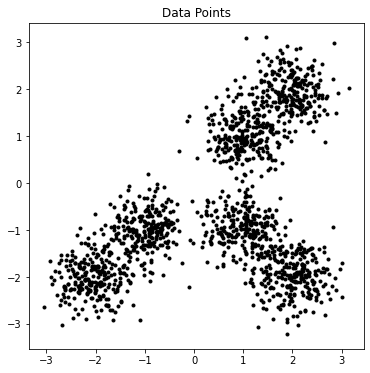

In [5]:
centers = [[1, 1], [-1, -1], [1, -1], [2, 2], [-2, -2], [2, -2]]
X, labels_true = make_blobs(n_samples=1500, centers=centers, cluster_std=0.4, random_state=5)
plt.subplots(figsize=(6, 6))
plt.plot(X[:, 0], X[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
             markeredgecolor='k', markersize=3, scalex=1, scaley=1)
plt.title('Data Points')

Put dummy data in Spark dataframe

In [6]:
schema = StructType([
    StructField('id', IntegerType(), False),
    StructField('value', ArrayType(DoubleType(), False), False)
])

# Convert list to RDD
rdd = spark.sparkContext.parallelize(zip(range(len(X)), X.tolist()))

# Create data frame
df = spark.createDataFrame(rdd,schema)

In [7]:
res = process_dbscan(spark, df, epsilon=0.3, min_pts=10, dist=euclidean, dim=2, checkpoint_dir="./checkpoint", operations=None)

22/07/27 14:51:41 WARN MemoryManager: Total allocation exceeds 95,00% (906 992 014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers
22/07/27 14:51:41 WARN MemoryManager: Total allocation exceeds 95,00% (906 992 014 bytes) of heap memory
Scaling row group sizes to 84,47% for 8 writers
22/07/27 14:51:42 WARN MemoryManager: Total allocation exceeds 95,00% (906 992 014 bytes) of heap memory
Scaling row group sizes to 96,54% for 7 writers


In [8]:
# Point is the ID
# Component is the cluster ID
res.show(10)

+-----+---------+----------+
|point|component|core_point|
+-----+---------+----------+
| 1128|        8|     false|
| 1296|        0|      true|
|  578|        0|      true|
|  819|        0|      true|
|  364|        0|      true|
|  773|        0|      true|
|  173|        0|      true|
| 1034|        8|      true|
| 1484|        8|      true|
| 1082|        0|      true|
+-----+---------+----------+
only showing top 10 rows



In [9]:
res.select('component').distinct().collect() # Three clear clusters

[Row(component=0), Row(component=8), Row(component=2)]

Merge original DF with the results of clustering

In [10]:
cluster_df = res.toPandas()
data_df = df.toPandas()
final_df = data_df.merge(cluster_df, how="left", left_on="id", right_on="point")
final_df['x_coord'] = final_df['value'].map(lambda x: x[0])
final_df['y_coord'] = final_df['value'].map(lambda x: x[1])

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

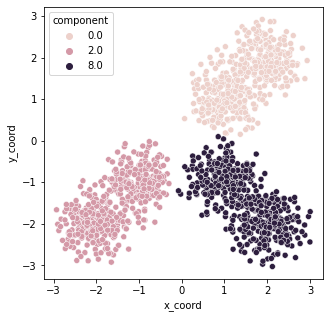

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='x_coord',y='y_coord',hue='component',data=final_df,legend='full', ax=ax)